# Fitting CHESS temperature dependent linecuts

## Import functions

In [1]:
from nxs_analysis_tools.datareduction import load_data, Scissors
from nxs_analysis_tools.chess import *

from lmfit.models import GaussianModel, LinearModel

## Create TempDependence object and load data

In [2]:
sample = TempDependence('example_data/sample_name')

In [3]:
sample.load_datasets()
# Or, load_transforms() if using data outputted from nxrefine

data:NXdata
  @axes = ['H', 'K', 'L']
  @signal = 'counts'
  H = float64(100)
  K = float64(150)
  L = float64(200)
  counts = float64(100x150x200)
data:NXdata
  @axes = ['H', 'K', 'L']
  @signal = 'counts'
  H = float64(100)
  K = float64(150)
  L = float64(200)
  counts = float64(100x150x200)
data:NXdata
  @axes = ['H', 'K', 'L']
  @signal = 'counts'
  H = float64(100)
  K = float64(150)
  L = float64(200)
  counts = float64(100x150x200)


## Perform linecuts

In [4]:
sample.cut_data(center=(0,0,0), window=(0.1,0.5,0.1))

{'15': NXdata('data'), '100': NXdata('data'), '300': NXdata('data')}

## The `LinecutModel` class

Each `TempDependence` object has a `LinecutModel` for each temperature, stored in the `.linecutmodels` attribute. When a linecut is performed using the `.cut_data()` method, these are automatically initialized with the x and y data from the linecut.

In [5]:
sample.linecutmodels

{'15': <nxs_analysis_tools.fitting.LinecutModel at 0x24c0d0196a0>,
 '100': <nxs_analysis_tools.fitting.LinecutModel at 0x24c0d00e850>,
 '300': <nxs_analysis_tools.fitting.LinecutModel at 0x24c0d00ed50>}

## Create `lmfit` model

Use the `.set_model_components()` method to set the model to be used for fitting the linecut. The `model_components` parameter must be a `Model`, `CompositeModel`, or `list` of `Model` objects.

In [6]:
# Using a list of Model objects
sample.set_model_components([GaussianModel(prefix='peak'), LinearModel(prefix='background')])

# Using a CompositeModel
sample.set_model_components(GaussianModel(prefix='peak') + LinearModel(prefix='background'))

Upon setting the model, the `.params` attribute of each `LinecutModel` is initialized with a `Parameters` object which holds the parameters for all components of the model.

In [7]:
sample.linecutmodels['15'].params

name,value,initial value,min,max,vary,expression
peakamplitude,1.00000000,None,-inf,inf,True,
peakcenter,0.00000000,None,-inf,inf,True,
peaksigma,1.00000000,None,0.00000000,inf,True,
backgroundslope,1.00000000,None,-inf,inf,True,
backgroundintercept,0.00000000,None,-inf,inf,True,
peakfwhm,2.35482000,None,-inf,inf,False,2.3548200*peaksigma
peakheight,0.39894230,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Performing an initial guess

Use the `.guess()` method to perform an initial guess, which will overwrite any changes made to the parameter values and constraints set in the `.params` attribute.

In [8]:
sample.guess()

To view the guessed initial values, we can inspect the `.params` attribute for any given dataset.

In [9]:
sample.linecutmodels['15'].params

name,value,initial value,min,max,vary,expression
peakamplitude,219.885366,219.88536567293792,-inf,inf,True,
peakcenter,0.00000000,0.0,-inf,inf,True,
peaksigma,0.06040268,0.06040268456375841,0.00000000,inf,True,
backgroundslope,2.3853e-14,2.3853065274578794e-14,-inf,inf,True,
backgroundintercept,180.019533,180.0195329458017,-inf,inf,True,
peakfwhm,0.14223745,None,-inf,inf,False,2.3548200*peaksigma
peakheight,1452.27938,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Visualize the initial guesses

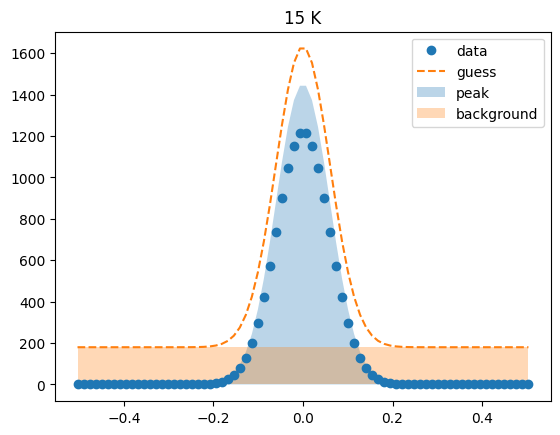

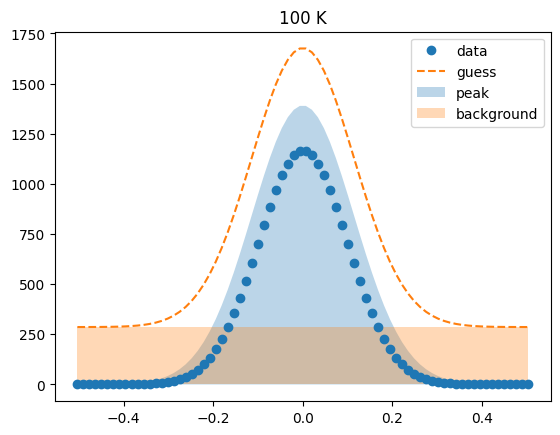

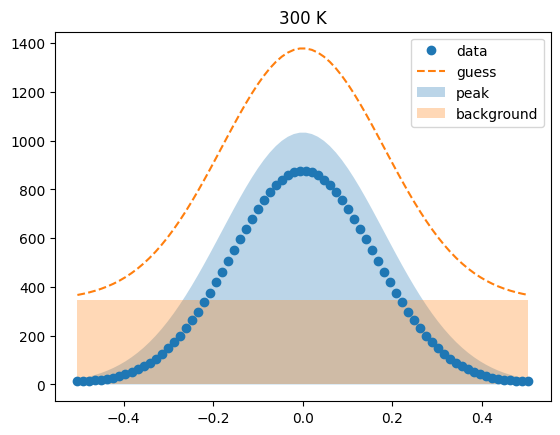

In [10]:
sample.plot_initial_guess()

## Set parameter constraints

All constraints are set by accessing the individiual parameters through the `.params` attribute. See [https://lmfit.github.io/lmfit-py/constraints.html](https://lmfit.github.io/lmfit-py/constraints.html) for more information on mathematical constraints allowed by `lmfit`.

In [11]:
# Constrain the peak amplitude to be positive
sample.linecutmodels['15'].params['peakamplitude'].set(min=0)

# Constrain the range of the peak center
sample.linecutmodels['15'].params['peakcenter'].set(min=-0.1, max=0.1)

If we inspect the `.params` attribute again, we should see that the constraints are implemented.

In [12]:
sample.linecutmodels['15'].params

name,value,initial value,min,max,vary,expression
peakamplitude,219.885366,219.88536567293792,0.00000000,inf,True,
peakcenter,0.00000000,0.0,-0.10000000,0.10000000,True,
peaksigma,0.06040268,0.06040268456375841,0.00000000,inf,True,
backgroundslope,2.3853e-14,2.3853065274578794e-14,-inf,inf,True,
backgroundintercept,180.019533,180.0195329458017,-inf,inf,True,
peakfwhm,0.14223745,None,-inf,inf,False,2.3548200*peaksigma
peakheight,1452.27938,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


It is practical in many cases to set a constraint for all datasets at once, since they are likely to have very similar data. For example, we may wish to constrain the peak center to range between -0.1 and 0.1 at all temperatures, with an initial value of 0.05.

Rather than accessing each temperature manually, we can use the `.params_set()` method of the `TempDependence` object to set a constraint on all the  `LinecutModel` objects at once.

In [13]:
sample.params_set(name='peakcenter', value=0.05, min=-0.1, max=0.1)

Now, we can examine the individual parameters of any `LinecutModel` and find that the constraint has been applied.

In [14]:
sample.linecutmodels['300'].params

name,value,initial value,min,max,vary,expression
peakamplitude,469.378240,469.37824009285373,-inf,inf,True,
peakcenter,0.05000000,0.05,-0.10000000,0.10000000,True,
peaksigma,0.18120805,0.18120805369127524,0.00000000,inf,True,
backgroundslope,1.1764e-14,1.1763681003221413e-14,-inf,inf,True,
backgroundintercept,345.254560,345.2545601000557,-inf,inf,True,
peakfwhm,0.42671235,None,-inf,inf,False,2.3548200*peaksigma
peakheight,1033.36927,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Perform the fit

The `.fit()` method here automatically assumes the parameter values and constraints currently stored in the `.params` attribute of each model, and feeds them to the `.fit()` method from `lmfit`. 

In [15]:
sample.fit()

Fits completed.


## Visualize the fits

Once the fit is complete, we can visualize the fit and the residuals using the `.plot_fit()` method of each `LinecutModel`.

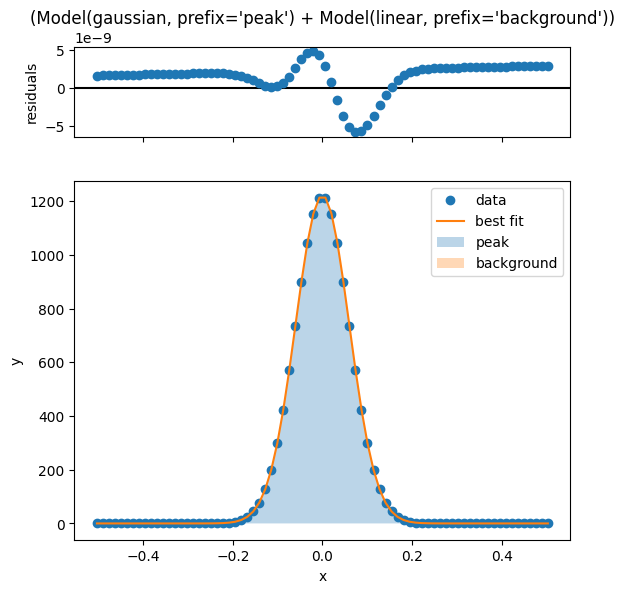

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 76
    # variables        = 5
    chi-square         = 5.0518e-16
    reduced chi-square = 7.1152e-18
    Akaike info crit   = -2995.97893
    Bayesian info crit = -2984.32527
    R-squared          = 1.00000000
[[Variables]]
    peakamplitude:        183.644087 +/- 2.0157e-10 (0.00%) (init = 219.8854)
    peakcenter:           3.2188e-13 +/- 6.2688e-14 (19.48%) (init = 0.05)
    peaksigma:            0.06000000 +/- 6.8400e-14 (0.00%) (init = 0.06040268)
    backgroundslope:     -1.2938e-09 +/- 1.9688e-10 (15.22%) (init = 2.385307e-14)
    backgroundintercept: -2.2492e-09 +/- 3.2821e-10 (14.59%) (init = 180.0195)
    peakfwhm:             0.14128920 +/- 1.6107e-13 (0.00%) == '2.3548200*peaksigma'
    peakheight:           1221.05658 +/- 1.2105e-09 (0.00%) == '0.3989423*peakamplitude/max(1e-15, peaksi

<Axes: xlabel='x', ylabel='y'>

In [16]:
sample.linecutmodels['15'].plot_fit()

## Visualize all fits

The `.plot_fit()` method of the `TempDependence` object prints fit results for all temperatures. The parameter `fit_report` (default `True`) determines whether the fit report is also printed.

Additionally, an optional Markdown heading can be displayed using the `mdheadings` parameter (default `False`).

### 15 K Fit Results

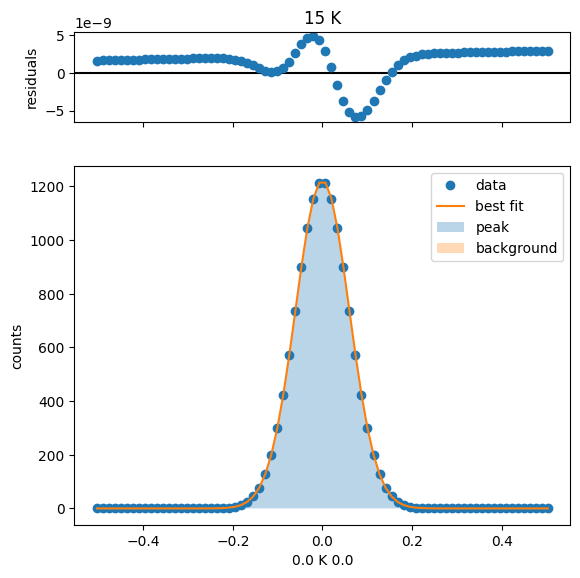

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 76
    # variables        = 5
    chi-square         = 5.0518e-16
    reduced chi-square = 7.1152e-18
    Akaike info crit   = -2995.97893
    Bayesian info crit = -2984.32527
    R-squared          = 1.00000000
[[Variables]]
    peakamplitude:        183.644087 +/- 2.0157e-10 (0.00%) (init = 219.8854)
    peakcenter:           3.2188e-13 +/- 6.2688e-14 (19.48%) (init = 0.05)
    peaksigma:            0.06000000 +/- 6.8400e-14 (0.00%) (init = 0.06040268)
    backgroundslope:     -1.2938e-09 +/- 1.9688e-10 (15.22%) (init = 2.385307e-14)
    backgroundintercept: -2.2492e-09 +/- 3.2821e-10 (14.59%) (init = 180.0195)
    peakfwhm:             0.14128920 +/- 1.6107e-13 (0.00%) == '2.3548200*peaksigma'
    peakheight:           1221.05658 +/- 1.2105e-09 (0.00%) == '0.3989423*peakamplitude/max(1e-15, peaksi

### 100 K Fit Results

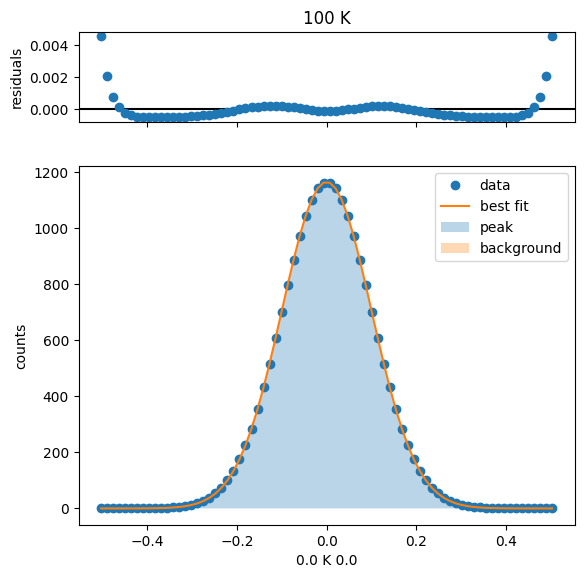

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 76
    # variables        = 5
    chi-square         = 5.9185e-05
    reduced chi-square = 8.3360e-07
    Akaike info crit   = -1058.98332
    Bayesian info crit = -1047.32965
    R-squared          = 1.00000000
[[Variables]]
    peakamplitude:        291.982900 +/- 1.1230e-04 (0.00%) (init = 397.8052)
    peakcenter:           1.4355e-09 +/- 3.0535e-08 (2127.06%) (init = 0.05)
    peaksigma:            0.09999993 +/- 3.5746e-08 (0.00%) (init = 0.114094)
    backgroundslope:      3.5175e-14 +/- 3.7546e-04 (1067401199923.84%) (init = 3.517481e-14)
    backgroundintercept:  5.6410e-04 +/- 1.5348e-04 (27.21%) (init = 286.2205)
    peakfwhm:             0.23548184 +/- 8.4175e-08 (0.00%) == '2.3548200*peaksigma'
    peakheight:           1164.84409 +/- 3.2630e-04 (0.00%) == '0.3989423*peakamplitude/max(1e

### 300 K Fit Results

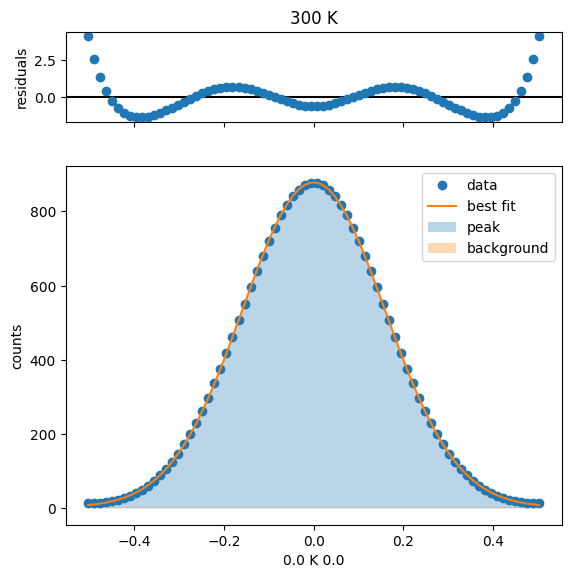

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 76
    # variables        = 5
    chi-square         = 85.5499422
    reduced chi-square = 1.20492876
    Akaike info crit   = 18.9958908
    Bayesian info crit = 30.6495575
    R-squared          = 0.99998814
##  Warning: uncertainties could not be estimated:
    backgroundslope:      at initial value
[[Variables]]
    peakamplitude:        349.382295 (init = 469.3782)
    peakcenter:           3.6202e-11 (init = 0.05)
    peaksigma:            0.15931867 (init = 0.1812081)
    backgroundslope:      1.1764e-14 (init = 1.176368e-14)
    backgroundintercept:  3.23457347 (init = 345.2546)
    peakfwhm:             0.37516678 == '2.3548200*peaksigma'
    peakheight:           874.871596 == '0.3989423*peakamplitude/max(1e-15, peaksigma)'


In [17]:
sample.plot_fit(mdheadings=True)

## Overlay all fits

It can also be helpful to overlay the plots of all fits on a single figure. To accomplish this, we can use the `.overlay_fits()` method. 

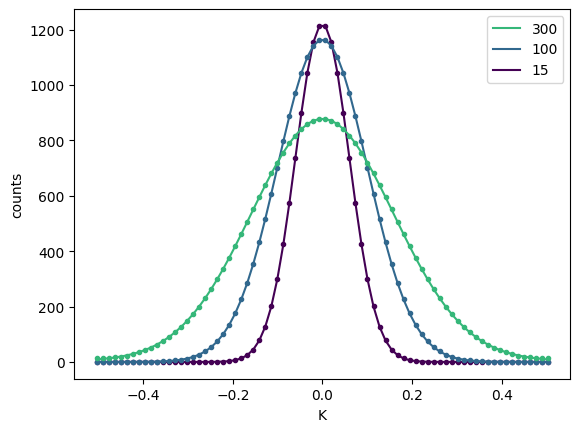

In [18]:
sample.overlay_fits()

The `numpoints` parameter specifies the number of points to use for the fit curve. A vertical offset may be specified using `vertical_offset` for clarity. The colormap is also customizable via the `cmap` argument, and other customizations can be passed to the plot functions for the data and fit components via `data_kwargs` and `fit_kwargs`, respectively.

c:\Users\steve\miniconda3\envs\nxs\Lib\site-packages\nxs_analysis_tools\chess.py:751: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(lm.x, lm.y + vertical_offset * i, '.', c=colors[i], **data_kwargs)


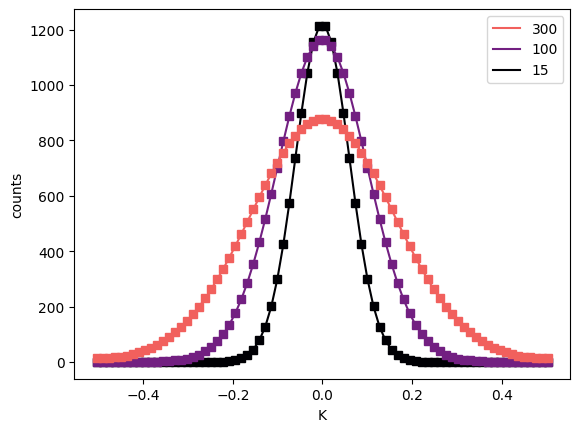

In [22]:
sample.overlay_fits(cmap='magma', data_kwargs={'marker':'s'})

## Performing a simple linecut with no customization

The `.fit_peak_simple()` method offers a quick but rudimentary way to fit a peak, using a pseudo-Voigt peak shape with a linear background.

In [20]:
sample.fit_peak_simple()

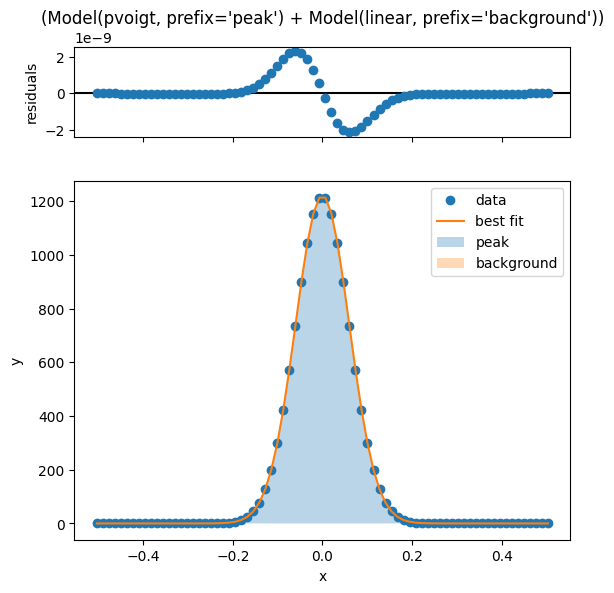

[[Model]]
    (Model(pvoigt, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 232
    # data points      = 76
    # variables        = 6
    chi-square         = 5.3822e-17
    reduced chi-square = 7.6888e-19
    Akaike info crit   = -3164.16080
    Bayesian info crit = -3150.17640
    R-squared          = 1.00000000
##  Warning: uncertainties could not be estimated:
    peakfraction:         at boundary
    backgroundslope:      at initial value
[[Variables]]
    peakamplitude:        183.644087 (init = 274.8567)
    peakcenter:           1.8081e-13 (init = 0)
    peaksigma:            0.07064460 (init = 0.06040268)
    peakfraction:         3.4722e-13 (init = 0.5)
    peakfwhm:             0.14128920 == '2.0000000*peaksigma'
    peakheight:           1221.05652 == '(((1-peakfraction)*peakamplitude)/max(1e-15, (peaksigma*sqrt(pi/log(2))))+(peakfraction*peakamplitude)/max(1e-15, (pi*peaksigma)))'
    backg

<Axes: xlabel='x', ylabel='y'>

In [21]:
sample.linecutmodels['15'].plot_fit()